# Demonstration of Authentrics.ai Static & Dynamic Analysis

## Setup

### Install dependencies and utility functions: This cell should be run once.

In [1]:
%%capture

%pip install matplotlib numpy pandas requests tqdm ipywidgets
%pip install --ignore-installed 'git+https://github.com/Authentrics-ai/authentrics-client.git@v1.1.0'

from pathlib import Path

import os
import authentrics_client as authrx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from datetime import datetime
import time
from tqdm.notebook import tqdm
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from threading import Thread
import contextlib

# Utility functions for loading indicators
@contextlib.contextmanager
def loading_spinner(message="Processing..."):
    """Context manager for showing a loading spinner"""
    spinner_widget = widgets.HTML(value=f"""
    <div style="display: flex; align-items: center; gap: 10px;">
        <div style="width: 20px; height: 20px; border: 2px solid #f3f3f3; border-top: 2px solid #3498db; border-radius: 50%; animation: spin 1s linear infinite;"></div>
        <span style="font-size: 14px; color: #555;">{message}</span>
    </div>
    <style>
    @keyframes spin {{
        0% {{ transform: rotate(0deg); }}
        100% {{ transform: rotate(360deg); }}
    }}
    </style>
    """)
    display(spinner_widget)
    try:
        yield
    finally:
        spinner_widget.close()

def show_progress_bar(total, description="Progress"):
    """Create and return a progress bar"""
    return tqdm(total=total, desc=description, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')

def wait_for_analytics(project_id, min_wait_time=30, max_wait_time=300, check_interval=10):
    """
    Wait for ALL analytics to be complete before continuing.
    This prevents NaN values from appearing in the summary table.
    """
    import time

    print("🔄 Waiting for analytics to process...")
    countdown_widget = widgets.HTML()
    display(countdown_widget)

    # Minimum wait with countdown
    for remaining in range(min_wait_time, 0, -1):
        countdown_widget.value = f"""
        <div style="display: flex; align-items: center; gap: 10px; margin: 10px 0;">
            <div style="width: 20px; height: 20px; border: 2px solid #f3f3f3; border-top: 2px solid #3498db; border-radius: 50%; animation: spin 1s linear infinite;"></div>
            <span style="font-size: 14px; color: #555;">Minimum wait period: {remaining} seconds remaining...</span>
        </div>
        <style>
        @keyframes spin {{
            0% {{ transform: rotate(0deg); }}
            100% {{ transform: rotate(360deg); }}
        }}
        </style>
        """
        time.sleep(1)

    # Poll until ALL analytics are complete
    start_polling = time.time()
    attempt = 1

    while (time.time() - start_polling) < (max_wait_time - min_wait_time):
        try:
            project = client.project.get_project_by_id(project_id)
            files = project["file_list"][1:]  # Skip base model

            # Check that ALL files have both weight and bias contributions
            files_missing_analytics = []
            for f in files:
                if (f.get("total_weight_contribution") is None or
                    f.get("total_bias_contribution") is None):
                    files_missing_analytics.append(f["file_name"])

            # Only continue if ALL analytics are complete
            if not files_missing_analytics:
                countdown_widget.value = """
                <div style="color: green; font-weight: bold; margin: 10px 0;">
                    ✅ All analytics are complete!
                </div>
                """
                return True

            # Show progress with specific missing files
            total_files = len(files)
            completed_files = total_files - len(files_missing_analytics)
            progress_pct = (completed_files / total_files * 100) if total_files > 0 else 0

            missing_display = ', '.join(files_missing_analytics[:3])
            if len(files_missing_analytics) > 3:
                missing_display += f" and {len(files_missing_analytics) - 3} more"

            countdown_widget.value = f"""
            <div style="display: flex; align-items: center; gap: 10px; margin: 10px 0;">
                <div style="width: 20px; height: 20px; border: 2px solid #f3f3f3; border-top: 2px solid #orange; border-radius: 50%; animation: spin 1s linear infinite;"></div>
                <span style="font-size: 14px; color: #555;">
                    Attempt {attempt}: {completed_files}/{total_files} files complete ({progress_pct:.1f}%)
                    <br/>⏳ Waiting for: {missing_display}
                </span>
            </div>
            <style>
            @keyframes spin {{
                0% {{ transform: rotate(0deg); }}
                100% {{ transform: rotate(360deg); }}
            }}
            </style>
            """
            attempt += 1
            time.sleep(check_interval)

        except Exception as e:
            print(f"⚠️ Error checking analytics status: {e}")
            time.sleep(check_interval)

    # Timeout reached - show final status
    try:
        project = client.project.get_project_by_id(project_id)
        files = project["file_list"][1:]
        files_missing_analytics = [f["file_name"] for f in files
                                 if (f.get("total_weight_contribution") is None or
                                     f.get("total_bias_contribution") is None)]

        if files_missing_analytics:
            countdown_widget.value = f"""
            <div style="color: red; font-weight: bold; margin: 10px 0;">
                ⚠️ Timeout: Analytics incomplete for {len(files_missing_analytics)} files.
                <br/>NaN values will appear for: {', '.join(files_missing_analytics[:5])}
                <br/>Consider increasing wait time or contacting support.
            </div>
            """
            return False
        else:
            countdown_widget.value = """
            <div style="color: green; font-weight: bold; margin: 10px 0;">
                ✅ All analytics completed just in time!
            </div>
            """
            return True
    except Exception as e:
        countdown_widget.value = f"""
        <div style="color: red; font-weight: bold; margin: 10px 0;">
            ❌ Error checking final status: {e}
        </div>
        """
        return False

### Contact Authentrics for the URL and user credentials info@authentrics.ai

In [2]:
DEMO_SERVER_URL = input("Enter your Authentrics URL: ")
PROJECT_NAME = "MNIST"

pd.options.display.precision = 5
pd.options.display.chop_threshold = None



### Input your classes used for classification here

In [3]:
classes = ["0","1","2","3","4","5","6","7","8","9"]

### Establish a session with Authentrics
- Rerun this cell if your session expires

In [4]:
client = authrx.AuthentricsClient(DEMO_SERVER_URL)
client.auth.login()
print("✅ Session established successfully!")

✅ Session established successfully!


### Generate a project in Authentrics to track checkpoints, and perform asynchronous analytics
1. Creates a project for checkpoint management.
2. **Option A**: Point to existing checkpoint storage (no data movement required).
3. **Option B**: Upload checkpoints directly through our client (automated storage and versioning).

In [5]:
projects = client.project.get_projects()
if projects is not None:
    project = next((p for p in projects if p["name"].startswith(PROJECT_NAME)), None)
    if project:
        client.project.delete_project(project["id"], hard_delete=False)

PROJECT_NAME = PROJECT_NAME + " " + str(int(datetime.now().timestamp()))
project = client.project.create_project(
    PROJECT_NAME,
    "A classification CNN for MNIST",
    authrx.FileType.ONNX,
)
project_id = project["id"]

### Point the authentrics file registry to the checkpoints using the api

In [6]:
print("Adding checkpoints to project...")
with show_progress_bar(6, "Adding checkpoints") as pbar:
    for i in range(6):
        client.checkpoint.add_external_checkpoint(
            project_id,
            f"demo-models/de-demo-checkpoints/altered_checkpoints/model_batch_0{i+1}.onnx",
            authrx.FileType.ONNX,
            file_name=f"checkpoint_{i+1}.onnx",
            tag=f"v{i+1}",
        )
        pbar.update(1)


project = client.project.get_project_by_id(project_id)
print(f"Project created with id: {project_id}")
print(f"Project name: {project['name']}")
for file in project["file_list"]:
    print(f"File name: {file['file_name']}")

# Wait for analytics to be processed before proceeding
print("\n" + "="*60)
print("📊 ANALYTICS PROCESSING")
print("="*60)
print("Authentrics is now computing analytics in the background.")
print("This includes weight contributions and bias scores for each checkpoint.")

analytics_ready = wait_for_analytics(project_id, min_wait_time=15, max_wait_time=300)
if not analytics_ready:
    print("\n❌ Analytics are not complete.")
    print("Please wait a moment longer and then continue. Please contact support if the issue persists.")

Adding checkpoints to project...


Adding checkpoints:   0%|          | 0/6 [00:00<?]

Project created with id: 68d199473bf3666e62ed726c
Project name: MNIST 1758566727
File name: checkpoint_1.onnx
File name: checkpoint_2.onnx
File name: checkpoint_3.onnx
File name: checkpoint_4.onnx
File name: checkpoint_5.onnx
File name: checkpoint_6.onnx

📊 ANALYTICS PROCESSING
Authentrics is now computing analytics in the background.
This includes weight contributions and bias scores for each checkpoint.
🔄 Waiting for analytics to process...


### Below we define helper functions for visualizing analytics and running inference


In [7]:
def softmax(x):
    """Compute softmax of a 1D array"""
    e = np.exp(x)
    return e / np.sum(e, axis=-1)

def display_sensitivity_results(result: dict, columns: list[str], classes: list[str]):
    """Display results in a table using Pandas"""
    series = {}
    for col in columns:
        arr = np.asarray(result[col]).flatten()
        series[col] = softmax(arr) * 100

    return pd.DataFrame(series, index=classes)

def plot_heatmap(results, layer_name):
    """Plot static analysis of several checkpoints using matplotlib"""
    arr = np.stack([
        result["absolute_bias_difference"][layer_name]
        for result in results
    ], axis=1)
    num_results = len(results)

    plt.matshow(arr)
    plt.colorbar(aspect=10)

    plt.xlabel("Checkpoint")
    plt.ylabel("Bias Shift")

    plt.xticks(range(num_results), np.arange(num_results) + 2)
    plt.yticks(list(range(len(classes))), sorted(classes))

    plt.show()

def plot_contributions(project_id):
    # Get files
    project = client.project.get_project_by_id(project_id)
    files = project['file_list']

    weights = [f['total_weight_contribution'] for f in files]
    bias = [f['total_bias_contribution'] for f in files]
    file_names = [f['file_name'] for f in files]

    # --- First plot: Weight Shifts ---
    fig1, ax1 = plt.subplots(figsize=(10, 7))
    ax1.plot(range(len(weights)), weights, marker='o', linestyle='-', alpha=0.6)
    ax1.set_xticks(range(len(weights)))
    ax1.set_xticklabels(file_names, rotation=45, ha='right')
    ax1.set_xlabel('Checkpoints')
    ax1.set_ylabel('Total Weight Shift')
    ax1.set_title('Weight Shifts by Training')
    fig1.tight_layout()

    # --- Second plot: Bias Shifts ---
    fig2, ax2 = plt.subplots(figsize=(10, 7))
    ax2.plot(range(len(bias)), bias, marker='o', linestyle='-', alpha=0.6)
    ax2.set_xticks(range(len(bias)))
    ax2.set_xticklabels(file_names, rotation=45, ha='right')
    ax2.set_xlabel('Checkpoints')
    ax2.set_ylabel('Total Bias Shift')
    ax2.set_title('Bias Shifts by Training')
    fig2.tight_layout()

    plt.show()

## Analytics Results

Authentrics computes analytics in the background to track model changes across training iterations.

1. **Weight/Bias shift tracking**: The plot below demonstrates the average weight/bias changes as percentages, tracking how model weights evolve from one checkpoint to the next during training.

2. **Integration ready**: This raw analytics data can trigger alerts for unusual changes or integrate with your existing business intelligence tools.

3. **Data availability**: If you don't see the graph, analytics are still processing. Wait a few minutes and rerun the cell.



### Weight/Bias shift per checkpoint

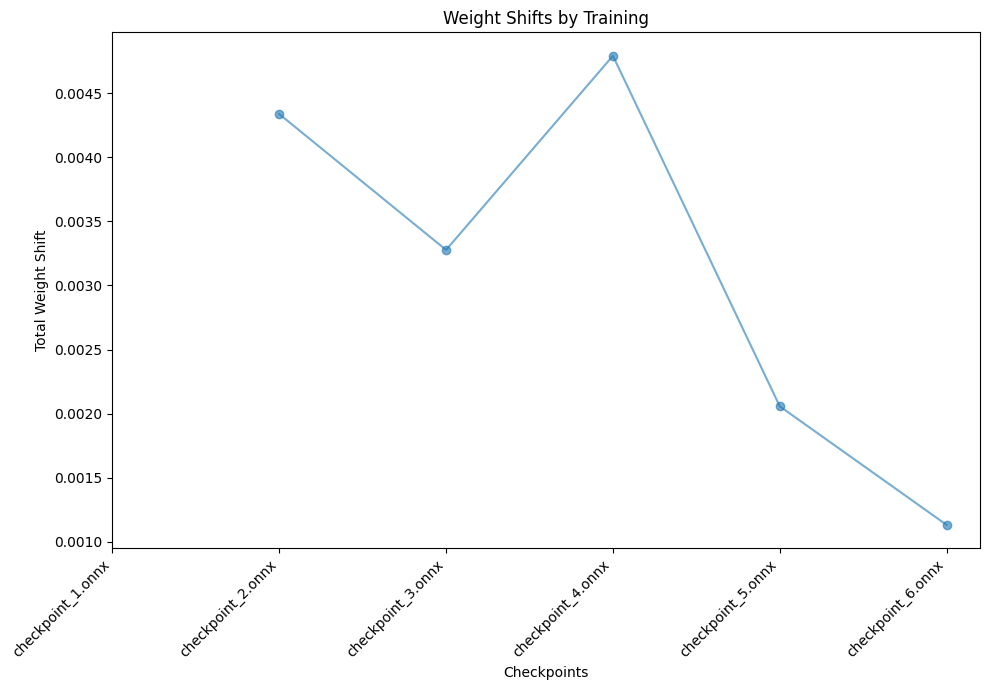

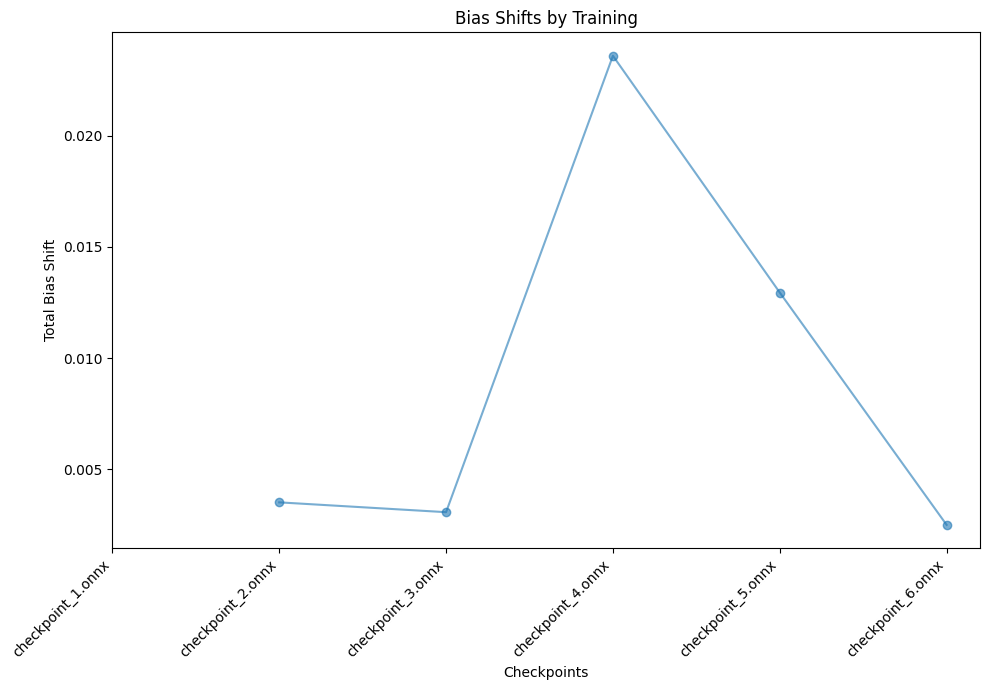

In [8]:
with loading_spinner("Generating Weight/Bias shift plot per checkpoints..."):
    plot_contributions(project_id)

### Static Analysis

Static analysis is fast, even for a large model. There is no inference performed; we only inspect the parameters within the checkpoint itself.

In [9]:
%%time
## Call Authentrics.ai software's static analysis
file_ids = [f["id"] for f in project["file_list"]]
with loading_spinner("Running static analysis..."):
    result = client.static.static_analysis(project_id=project_id, checkpoint_id=file_ids[1])

CPU times: user 2.82 ms, sys: 1.32 ms, total: 4.14 ms
Wall time: 643 ms


This lists all the names of the bias parameters within the model.

In [10]:
list(result["absolute_bias_difference"].keys())

['conv1.bias', 'conv2.bias', 'fc1.bias', 'fc2.bias']

Performing static analysis on all the checkpoints can provide an overview of the model's transformation.

In [11]:
%%time
## Call Authentrics.ai software's static analysis for each checkpoint file
with loading_spinner("Running static analysis for each checkpoint file..."):
    results = [
        client.static.static_analysis(project_id=project_id, checkpoint_id=project["file_list"][i]["id"])
        for i in range(1, 6)
    ]
print("✅ Static analysis complete")

✅ Static analysis complete
CPU times: user 10.9 ms, sys: 3.72 ms, total: 14.7 ms
Wall time: 2.35 s


The raw results variable will have a lot of information.  Please include the layer of interest to look at the changes per class

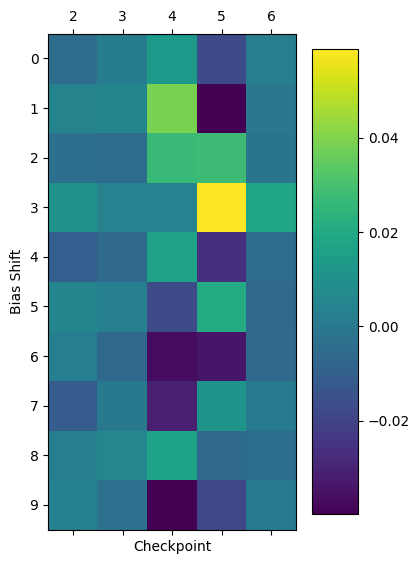

In [12]:
with loading_spinner("Generating heatmap..."):
    layer_name = "fc2.bias" # @param {"type":"string"}
    plot_heatmap(results, layer_name)

#### Authentrics software enables rapid identification of critical training issues

Integration into your training workflow enables proactive issue detection, preventing problematic models from reaching production.

### Dynamic Analysis With Sensitivity

In [13]:
stimulus_name = "mnist_stim.csv" # @param {"type":"string"}

# Include your sample image/stimulus here to run inference

In [14]:
filepath = f"{stimulus_name}"

#### Vary the effect of the data in checkpoint 6 by 2%

In [15]:
%%time
## Call Authentrics.ai software's sensitivity analysis
print("Running sensitivity analysis...")
amplitude = 0.02
with loading_spinner("Running sensitivity analysis..."):
    result = client.dynamic.sensitivity_analysis(
        project_id,
        project["file_list"][5]["id"],
        stimulus_path=filepath,
        amplitude=amplitude,
    )
print(f"✅ Sensitivity analysis complete. Data attenuated by {amplitude}%.")

Running sensitivity analysis...


✅ Sensitivity analysis complete. Data attenuated by 0.02%.
CPU times: user 2.84 ms, sys: 1.23 ms, total: 4.08 ms
Wall time: 689 ms


Test the Accuracy of the model after running sensitivity analysis

In [16]:
display_sensitivity_results(result, ["model_output", "attenuated_model_output"], classes)

,model_output,attenuated_model_output
0,2.92495e-03,2.99198e-03
1,7.12434e-03,7.10766e-03
2,9.99017e+01,9.98988e+01
3,3.81637e-03,3.88208e-03
4,1.13622e-05,1.14398e-05
5,8.13864e-02,8.40700e-02
6,6.87266e-04,7.28652e-04
7,4.07145e-04,4.18932e-04
8,1.90754e-03,2.00659e-03
9,1.21445e-07,1.28117e-07


#### Vary the effect of the data in checkpoint 6 by 4%

In [17]:
%%time
## Call Authentrics.ai software's sensitivity analysis
print("Running sensitivity analysis...")
amplitude = 0.04
with loading_spinner("Running sensitivity analysis..."):
    result = client.dynamic.sensitivity_analysis(
        project_id,
        project["file_list"][5]["id"],
        stimulus_path=filepath,
        amplitude=amplitude,
    )
print(f"✅ Sensitivity analysis complete. Data attenuated by {amplitude}%.")

Running sensitivity analysis...


✅ Sensitivity analysis complete. Data attenuated by 0.04%.
CPU times: user 2.57 ms, sys: 1.39 ms, total: 3.96 ms
Wall time: 621 ms


Test the Accuracy of the model after running sensitivity analysis

In [18]:
display_sensitivity_results(result, ["model_output", "attenuated_model_output"], classes)

,model_output,attenuated_model_output
0,2.92495e-03,3.05979e-03
1,7.12434e-03,7.09085e-03
2,9.99017e+01,9.98958e+01
3,3.81637e-03,3.94870e-03
4,1.13622e-05,1.15177e-05
5,8.13864e-02,8.68229e-02
6,6.87266e-04,7.72381e-04
7,4.07145e-04,4.31011e-04
8,1.90754e-03,2.11012e-03
9,1.21445e-07,1.35126e-07
